In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
X_train, y_train = pd.read_csv('../data/X_train.csv'), pd.read_csv('../data/y_train.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=y_train
)

In [4]:
y_train = np.array([1 if e=="S" else 0 for e in y_train.to_numpy()]).reshape((-1, 1))
y_test = np.array([1 if e=="S" else 0 for e in y_test.to_numpy()]).reshape((-1, 1))

## 7. Machine Learning Model Building

### Model training

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()        
        self.input_size = input_size
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.softmax = nn.Softmax(dim=1)
        
    def get_params(self):
        return self.layers.parameters()
    
    def forward(self, X):
        return self.layers(X)
    
    def predict(self, X):
        logits = self.layers(X)
        return self.softmax(logits)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classifier = MLP(input_size=X_train.shape[1])
classifier.to(device)

loss = nn.BCEWithLogitsLoss()

params = classifier.get_params()
optimizer = torch.optim.Adam(params)

In [7]:
train_dataset = TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [8]:
epochs = 100
losses = []

# train loop
for epoch in tqdm(range(epochs)):
    loss_sum = 0
    count = 0
    
    for it, (X, y) in enumerate(train_loader):
        X = X.to(device).detach().clone()
        y = y.to(device).detach().clone()
                
        optimizer.zero_grad()
        
        result = classifier(X)
        LOSS = loss(y, result)
        loss_sum += LOSS
        
        LOSS.backward()
        optimizer.step()
        
        count += 1
        
    losses.append(loss_sum/count)

100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


### Performance on training set

In [22]:
classifier.eval()

labels = []
preds = []

with torch.no_grad():
    for it, (X, y) in enumerate(train_loader):
        X = X.to(device).detach().clone()
        
        result = classifier.predict(X)
        
        labels.append(y.numpy().astype(int))
        preds.append(torch.round(result).cpu().numpy().astype(int))
        
labels = np.squeeze(np.vstack(labels))
preds = np.squeeze(np.vstack(preds))

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       281
           1       0.71      1.00      0.83       681

    accuracy                           0.71       962
   macro avg       0.35      0.50      0.41       962
weighted avg       0.50      0.71      0.59       962



c:\Users\lucas\miniconda3\envs\torch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\miniconda3\envs\torch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\miniconda3\envs\torch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Text(70.72222222222221, 0.5, 'Real')

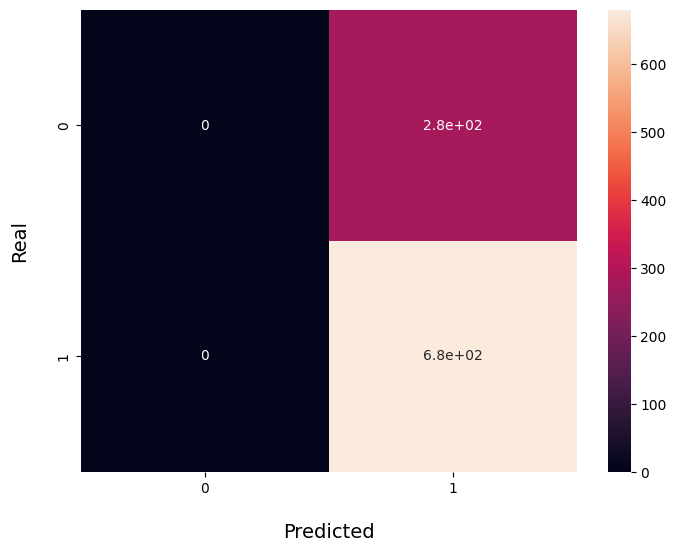

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

cf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6), dpi=100)

ax = sns.heatmap(cf_matrix, annot=True)

# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(target_names)
 
# set y-axis label and ticks
ax.set_ylabel("Real", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(target_names)

## 8. Model Evaluation

In [29]:
classifier.eval()

test_labels = []
test_preds = []

with torch.no_grad():
    for it, (X, y) in enumerate(test_loader):
        X = X.to(device).detach().clone()
        
        result = classifier.predict(X)
        
        test_labels.append(y.numpy().astype(int))
        test_preds.append(torch.round(result).cpu().numpy().astype(int))
        
test_labels = np.squeeze(np.vstack(test_labels))
test_preds = np.squeeze(np.vstack(test_preds))

In [30]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.71      1.00      0.83        76

    accuracy                           0.71       107
   macro avg       0.36      0.50      0.42       107
weighted avg       0.50      0.71      0.59       107



c:\Users\lucas\miniconda3\envs\torch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\miniconda3\envs\torch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\miniconda3\envs\torch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Text(70.72222222222221, 0.5, 'Real')

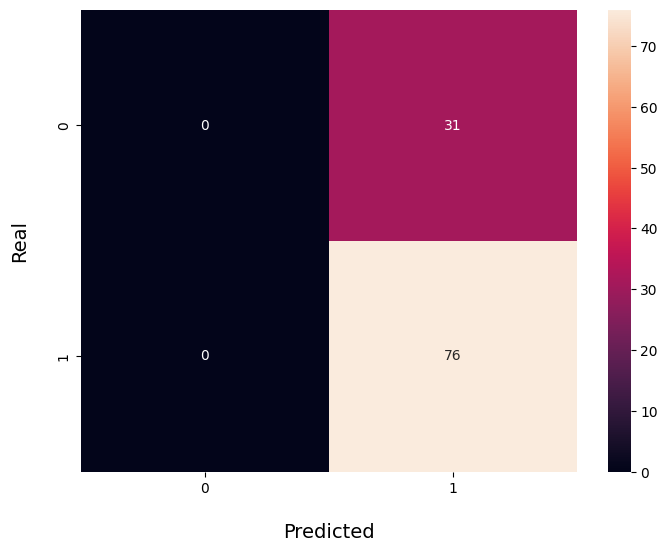

In [31]:
cf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8,6), dpi=100)

ax = sns.heatmap(cf_matrix, annot=True)

# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(target_names)
 
# set y-axis label and ticks
ax.set_ylabel("Real", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(target_names)